In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import sys
#!{sys.executable} -m pip install openpyxl
#import sys
#!{sys.executable} -m pip install --upgrade pandas
# Not able to upgrade pandas or openpyxl on server so we use a .xls file instead

## Load data

In [37]:
# Set the results directory and key script variables
directory = '//school-les-m.shares.deakin.edu.au/school-les-m/Planet-A/Food-Systems/Meta_analysis/GFSI-MRM/GFSI-MRM/'
results_date = '2024-11-01'
penalty = 'no' # Introduce penalty for very increasing ambition

boundaries = ['Biogeochemical_Flows', 'Climate_Change', 'Freshwater_Use', 'Land_system_change']

# These are for correcting the names in plots
boundaries_name = {'Biogeochemical_Flows': 'Nutrient cycles: N & P', 'Climate_Change':'GHG emissions', 
                   'Freshwater_Use':'Water withdrawals', 'Land_system_change':'Agricultural area', 'all_boundaries':'All environmental limits'}
solutions_name = {'Pop_levels':'Population',  'Diet':'Diet', 'Plant_kcal':'Plant kcal', 'Waste':'Waste',  'Yield_levels':'Yield',  'Feed_efficiency':'Feed efficiency',  
                  'Feed_composition':'Feed composition',  'WUEinc': 'Water-use efficiency', 'Carbon_price':'Carbon price',  'N_management':'N management'}
risk_colour = {'RED':'red', 'ORANGE':'orange', 'YELLOW':'#ffe66d', 'GREEN': 'green'}
risk_label = {'RED':'Very high risk', 'ORANGE':'High risk', 'YELLOW':'Moderate risk', 'GREEN': 'Safe'}

#indicators = ['CH4', 'CO2_LUC', 'N2O', 'Nfert','Pfert', 'Psurplus', 'Nsurplus', 'Cropland','Pasture', 'Water']

# Create an empty dictionary to record results per each boundary and each indicator in a dataframe
results_dict = {}

results_dict_ind = {}

# Read the boundary-level results
for b in boundaries:
    results_dict[b] = pd.read_csv(directory+'Outputs/Risk_estimates/'+b+'_'+results_date+'.csv', converters={'Plant_kcal':str,'Carbon_price':str, 'Yield_levels':str, 'WUEinc':str})
    #results_dict[b] = results_dict[b].drop(columns=['Unnamed: 0', 'System']) # Drop unnecessary columns
    results_dict[b] = results_dict[b].drop(columns=['System']) # Drop unnecessary columns
    results_dict[b]['Pop_levels'] = results_dict[b]['Pop_levels'].round(decimals = 1) # Rounding to one decimal place
        
# Read the bounrday's reference levels
ref_levels = pd.read_excel(directory+'Input_data\Scenario_settings/New_scenario_levels.xls', sheet_name='Sheet1', 
                           converters={'Plant_kcal':str,'Carbon_price':str, 'Yield_levels':str, 'WUEinc':str})
# Not able to upgrade pandas or openpyxl on server so we use a .xls file instead

ref_levels = ref_levels.drop(columns="P_management") # P_management removed from data.frame as only average N/P risk is plotted
ref_levels['Pop_levels'] = ref_levels['Pop_levels'].round(decimals = 1) # Rounding to one decimal place

if penalty=='yes':
    ref_levels['Trend_deviation'] = [-1,0,1,4]

# Create a list of all solutions
solutions = list(ref_levels)
del solutions[:2]
#solutions.remove('P_management') # Removing solutions associated with P since only aggregated boundary used

In [3]:
ref_levels

,Level,Trend_deviation,Pop_levels,Diet,Plant_kcal,Waste,Yield_levels,Feed_efficiency,Feed_composition,WUEinc,Carbon_price,N_management
0,Low,-1,10.1,RICH DIET,2900,BAU_High,1.15,STAGNANT,LOW GRAIN/HIGH GRASS,0,0,Current
1,Medium,0,9.7,BAU DIET,2700,Current,1.3,TREND,TREND,0.05,25,"+10% NUE,+10% REC"
2,High,1,9.5,REDUCED MEAT,2500,BAU_Low,1.45,ACCELERATED,INTENSIFIED,0.1,100,"+20% NUE,+20% REC"
3,Very High,2,9.1,LOW ASF,2300,Half,1.6,HIGH,HIGH GRAIN/LOW GRASS,0.15,200,"+30% NUE,30% REC"


In [33]:
results_dict

{'Biogeochemical_Flows':        Pop_levels       Diet Plant_kcal     Waste Yield_levels  \
 0             9.1   BAU DIET       2300  BAU_High         1.15   
 1             9.1   BAU DIET       2300  BAU_High         1.15   
 2             9.1   BAU DIET       2300  BAU_High         1.15   
 3             9.1   BAU DIET       2300  BAU_High         1.15   
 4             9.1   BAU DIET       2300  BAU_High         1.15   
 ...           ...        ...        ...       ...          ...   
 65531        10.1  RICH DIET       2900      Half          1.6   
 65532        10.1  RICH DIET       2900      Half          1.6   
 65533        10.1  RICH DIET       2900      Half          1.6   
 65534        10.1  RICH DIET       2900      Half          1.6   
 65535        10.1  RICH DIET       2900      Half          1.6   
 
       Feed_efficiency      Feed_composition       N_management    Pred_avg  \
 0         ACCELERATED  HIGH GRAIN/LOW GRASS            Current  145.027064   
 1         A

In [5]:
# For example, I call the results for Biogeochemical_Flows_N
pd.unique(results_dict['Biogeochemical_Flows']['N_management'])

array(['Current', '+10% NUE,+10% REC', '+20% NUE,+20% REC',
       '+30% NUE,30% REC'], dtype=object)

In [6]:
pd.unique(results_dict['Land_system_change']['Diet'])

array(['BAU DIET', 'LOW ASF', 'REDUCED MEAT', 'RICH DIET'], dtype=object)

## Compute solution ambitions based on BAU deviation and average risk across all boundaries

In [7]:
# The first step to find the Pareto scenarios is to calculate the average solution ambition and risk across all boundaries combined. 
# The solution ambition levels are categorical in the datasets. Using this categorical value and in each scenario,
# we measure the unit of deviation from trend per each solution and take the average of all deviations 
# to come up with a single number solution ambition value per scenario. 
# We also take an average for risk across all boundaries. This process is implemented as follows. 

# First, compute ambition of levels of solutions related to each boundary
# temp_results_dict is the same as results_dict, but it has new column for average ambitions and riska cross all bourndaries and the same per each boundary., . 
temp_results_dict2 = {}
for b in boundaries:
    temp_results_dict2[b] = results_dict[b].copy() # A new dataframe for each boundary with a new column for trend deviation
    temp_results_dict2[b].rename(columns={'Risk': 'Risk_'+b}, inplace=True)
    #temp_results_dict2[b].rename(columns={'RiskCol': 'RiskCol_'+b}, inplace=True)
    temp_results_dict2[b].rename(columns={'Pred_avg': 'Pred_avg_'+b}, inplace=True)
    temp_results_dict2[b].rename(columns={'Max': 'Max_'+b}, inplace=True)
    temp_results_dict2[b].rename(columns={'Min': 'Min_'+b}, inplace=True)
    temp_results_dict2[b].rename(columns={'Mode': 'Mode_'+b}, inplace=True)
    temp_results_dict2[b].rename(columns={'Pred_SD': 'Pred_SD_'+b}, inplace=True)
    

# Find solutions in each boundary as a list. Add to it the Risk of each boundary too.
solrisk_dict = {}
for b in boundaries:
    solrisk_dict[b] = []
    for s, solution in enumerate(solutions):
        if solution in list(results_dict[b]):
            solrisk_dict[b].append(solution)
    solrisk_dict[b] = solrisk_dict[b]+['Risk_'+b,'Pred_avg_'+b, 'Max_'+b, 'Min_'+b, 'Mode_'+b, 'Pred_SD_'+b]
    #solrisk_dict[b] = solrisk_dict[b]+['Risk_'+b, 'RiskCol_'+b, 'Pred_avg_'+b, 'Max_'+b, 'Min_'+b, 'Mode_'+b, 'Pred_SD_'+b]


# Turn each solution level from the scenario framework into a dictionary.
sol_dev = {}
for s in solutions:
    sol_dev[s] = ref_levels.set_index(s).to_dict()['Trend_deviation']
    

# Map the solution level names in pandas column with the generated dict. This well generate dataframe with ambition per boundary
sol_dict = {} # a dictionary which entails the list all solution in each boundary
for b in boundaries:
    #sol_dict[b] = list(set(solrisk_dict[b])-set(['Risk_'+b, 'RiskCol_'+b, 'Pred_avg_'+b, 
    #                                             'Max_'+b, 'Min_'+b, 'Mode_'+b, 'Pred_SD_'+b]))
    sol_dict[b] = list(set(solrisk_dict[b])-set(['Risk_'+b, 'Pred_avg_'+b, 
                                                 'Max_'+b, 'Min_'+b, 'Mode_'+b, 'Pred_SD_'+b]))
    for s in sol_dict[b]:
        temp_results_dict2[b][s] = temp_results_dict2[b][s].map(sol_dev[s])    
    temp_results_dict2[b]['Ambition_'+b] = temp_results_dict2[b][sol_dict[b]].mean(axis=1)
    
    
print('Each boundary scenario ambitions computed')



# Second, combine all per boundary dataframes to calculate avergae risk and ambition across all boundaries.
# Find common solution columns between all dataframes. This will be needed to merge all boundary scenarios  on common solutions
#gen_col = ['Max', 'Min', 'Risk', 'Mode','RiskCol','Pred_SD', 'Pred_avg']
gen_col = ['Max', 'Min', 'Risk', 'Mode','Pred_SD', 'Pred_avg','Pred_lwr','Risk_lwr','Pred_upr','Risk_avg','Risk_upr']
comm_sol = list(set(list(set(results_dict['Biogeochemical_Flows']) #& set(results_dict['Biogeochemical_Flows_P']) 
     & set(results_dict['Climate_Change']) & set(results_dict['Freshwater_Use']) 
     & set(results_dict['Land_system_change'])))-set(gen_col))
    
    
# Combine scenarios from all boudnaries and merge them on their common solution colums. It's not the most effieict way, 
# But the boundary darafarems need to be merged one by one as the common solutions between them are differnet. 

# Add ambition per boundary to the list of columns to be integrated.
for b in boundaries:
    solrisk_dict[b].append('Ambition_'+b)


All_results_dict = temp_results_dict2['Biogeochemical_Flows'][solrisk_dict['Biogeochemical_Flows']]
#All_results_dict = pd.merge(temp_results_dict2['Biogeochemical_Flows_N'][solrisk_dict['Biogeochemical_Flows_N']], 
#                            temp_results_dict2['Biogeochemical_Flows_P'][solrisk_dict['Biogeochemical_Flows_P']], 
#                            how='left', on=comm_sol)
#print('Biogeochemical_Flows_N and Biogeochemical_Flows_P combined')

All_results_dict = pd.merge(All_results_dict, 
                            temp_results_dict2['Freshwater_Use'][solrisk_dict['Freshwater_Use']], 
                            how='left', on=comm_sol)

print('Freshwater_Use combined')


All_results_dict = pd.merge(All_results_dict, 
                            temp_results_dict2['Land_system_change'][solrisk_dict['Land_system_change']], 
                            how='left', on=comm_sol)
print('Land_system_change combined')


All_results_dict = pd.merge(All_results_dict, 
                            temp_results_dict2['Climate_Change'][solrisk_dict['Climate_Change']], 
                            how='left', on=comm_sol)

# Carbon price no longer a matching variable
#+['Carbon_price'])

print('Climate_Change combined')


# Compute averege ambition and risk across all boundaries and in each individual boundary as new columns
All_results_dict['Ambition_all_boundaries'] = All_results_dict[solutions].mean(axis=1)

all_risk_list = []
for b in boundaries:
    all_risk_list.append('Risk_'+b) 

All_results_dict['Risk_all_boundaries'] = All_results_dict[all_risk_list].mean(axis=1)

print('All boundary scenario ambitions computed')


# Remap the all results dataframe solution ambition values back to their original level names
inv_sol_dev = {}
for s in solutions:
    inv_sol_dev[s] = {v: k for k, v in sol_dev[s].items()} 
    All_results_dict[s] = All_results_dict[s].map(inv_sol_dev[s])
    
for b in boundaries:
    for s in sol_dict[b]:
        temp_results_dict2[b][s] = temp_results_dict2[b][s].map(inv_sol_dev[s])
    
print('Scenario ambition numbers were mapped back to their original level names')
    
# Reorder the columns
all_cols_list = []
for b in boundaries:
    all_cols_list.append('Risk_'+b)
    all_cols_list.append('Ambition_'+b)
    #all_cols_list.append('RiskCol_'+b)
    all_cols_list.append('Pred_avg_'+b)
    all_cols_list.append('Max_'+b)
    all_cols_list.append('Min_'+b)
    all_cols_list.append('Mode_'+b)
    all_cols_list.append('Pred_SD_'+b)
    
    
All_results_dict = All_results_dict[solutions+all_cols_list+['Risk_all_boundaries', 'Ambition_all_boundaries']]



Each boundary scenario ambitions computed
Freshwater_Use combined
Land_system_change combined
Climate_Change combined
All boundary scenario ambitions computed
Scenario ambition numbers were mapped back to their original level names


In [8]:
All_results_dict

,Pop_levels,Diet,Plant_kcal,Waste,Yield_levels,Feed_efficiency,Feed_composition,WUEinc,Carbon_price,N_management,...,Pred_SD_Freshwater_Use,Risk_Land_system_change,Ambition_Land_system_change,Pred_avg_Land_system_change,Max_Land_system_change,Min_Land_system_change,Mode_Land_system_change,Pred_SD_Land_system_change,Risk_all_boundaries,Ambition_all_boundaries
0,9.1,BAU DIET,2300,BAU_High,1.15,ACCELERATED,HIGH GRAIN/LOW GRASS,0,0,Current,...,208.664973,0.7942,0.714286,4522.460127,5460,3019.28,3308.8,440.096147,0.773200,0.2
1,9.1,BAU DIET,2300,BAU_High,1.15,ACCELERATED,HIGH GRAIN/LOW GRASS,0,25,Current,...,208.664973,0.7942,0.714286,4522.460127,5460,3019.28,3308.8,440.096147,0.768250,0.3
2,9.1,BAU DIET,2300,BAU_High,1.15,ACCELERATED,HIGH GRAIN/LOW GRASS,0,100,Current,...,208.664973,0.7942,0.714286,4522.460127,5460,3019.28,3308.8,440.096147,0.761300,0.4
3,9.1,BAU DIET,2300,BAU_High,1.15,ACCELERATED,HIGH GRAIN/LOW GRASS,0,200,Current,...,208.664973,0.7942,0.714286,4522.460127,5460,3019.28,3308.8,440.096147,0.752275,0.5
4,9.1,BAU DIET,2300,BAU_High,1.15,ACCELERATED,HIGH GRAIN/LOW GRASS,0.05,0,Current,...,194.934356,0.7942,0.714286,4522.460127,5460,3019.28,3308.8,440.096147,0.758025,0.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048571,10.1,RICH DIET,2900,Half,1.6,TREND,TREND,0.1,200,"+30% NUE,30% REC",...,220.854525,0.9747,0.142857,5681.843595,5460,3019.28,3308.8,635.195966,0.764212,0.6
1048572,10.1,RICH DIET,2900,Half,1.6,TREND,TREND,0.15,0,"+30% NUE,30% REC",...,211.547248,0.9747,0.142857,5681.843595,5460,3019.28,3308.8,635.195966,0.752812,0.4
1048573,10.1,RICH DIET,2900,Half,1.6,TREND,TREND,0.15,25,"+30% NUE,30% REC",...,211.547248,0.9747,0.142857,5681.843595,5460,3019.28,3308.8,635.195966,0.752812,0.5
1048574,10.1,RICH DIET,2900,Half,1.6,TREND,TREND,0.15,100,"+30% NUE,30% REC",...,211.547248,0.9747,0.142857,5681.843595,5460,3019.28,3308.8,635.195966,0.752787,0.6


## Identify the pareto front

In [9]:
# Identify the pareto front
import pareto 



p_front = {}
pd_p_front = {}
obj1 = {}
obj2 = {}


# Compute the pareto front for all boundaries based on aggregate risk and ambition and 
# per each boundary based on ambition for solutions of each boundary    
for b in ['all_boundaries']:
    df = All_results_dict
    obj1[b] = df.columns.get_loc("Risk_"+b)   # The column index of risk as objective 1 
    obj2[b] = df.columns.get_loc("Ambition_"+b)   #  The column index of Trend_deviation as objective 2
    np_results_dict = df.to_numpy() # Convert the dataframe to numpy for the pareto.eps_sort function
    p_front[b] = pareto.eps_sort(tables=np_results_dict, objectives=[obj1[b], obj2[b]]) # Pareto front as a 2D list
    pd_p_front[b] = pd.DataFrame(p_front[b], columns=list(df)) # Convert 2D list Pareto front to a dataframe
    
    print(b+' pareto front completed.')
    
for b in boundaries:
    df = temp_results_dict2[b]
    obj1[b] = df.columns.get_loc("Risk_"+b)   # The column index of risk as objective 1 
    obj2[b] = df.columns.get_loc("Ambition_"+b)   #  The column index of Trend_deviation as objective 2
    np_results_dict = df.to_numpy() # Convert the dataframe to numpy for the pareto.eps_sort function
    p_front[b] = pareto.eps_sort(tables=np_results_dict, objectives=[obj1[b], obj2[b]]) # Pareto front as a 2D list
    pd_p_front[b] = pd.DataFrame(p_front[b], columns=list(df)) # Convert 2D list Pareto front to a dataframe
    
    print(b+' pareto front completed.')


all_boundaries pareto front completed.
Biogeochemical_Flows pareto front completed.
Climate_Change pareto front completed.
Freshwater_Use pareto front completed.
Land_system_change pareto front completed.


In [22]:
## Filter scenarios that meet multiple conditions

High_threshold = 0.5
Low_threshold = 0.33

# All scenarios that ensure <0.5 Risk across the boundaries

All_results_reduced_risk = All_results_dict.query('Risk_Climate_Change <= 0.50 & Risk_Land_system_change <= 0.50 & Risk_Biogeochemical_Flows <= 0.50 & Risk_Freshwater_Use <= 0.50')

# All scenarios that ensure <0.3 Risk across the boundaries
All_results_low_risk = All_results_dict.query('Risk_Climate_Change <= 0.333333333333 & Risk_Land_system_change <= 0.33333333333 & Risk_Biogeochemical_Flows <= 0.33333333333 & Risk_Freshwater_Use <= 0.33333333333')

In [23]:
len(All_results_reduced_risk)

8448

In [24]:
len(All_results_low_risk)

204

In [13]:
penalty

'no'

In [20]:
## Write out complete dictionary
#import feather
#path = 'my_data.feather'
#feather.write_dataframe(df, path)
if penalty=='yes':
    All_results_dict.to_csv(directory+'Outputs/Pareto_analysis+plots/All_merged_scenarios_penalty_'+results_date+'.csv',index=False)
else:    
    All_results_dict.to_csv(directory+'Outputs/Pareto_analysis+plots/All_merged_scenarios_'+results_date+'.csv',index=False)


In [25]:
All_results_low_risk.sort_values(by=['Ambition_all_boundaries'])

,Pop_levels,Diet,Plant_kcal,Waste,Yield_levels,Feed_efficiency,Feed_composition,WUEinc,Carbon_price,N_management,...,Pred_SD_Freshwater_Use,Risk_Land_system_change,Ambition_Land_system_change,Pred_avg_Land_system_change,Max_Land_system_change,Min_Land_system_change,Mode_Land_system_change,Pred_SD_Land_system_change,Risk_all_boundaries,Ambition_all_boundaries
359859,9.5,LOW ASF,2500,Half,1.6,HIGH,LOW GRAIN/HIGH GRASS,0,200,"+30% NUE,30% REC",...,167.189777,0.0720,1.285714,3070.649418,5460,3019.28,3308.8,325.017935,0.163350,1.2
80291,9.1,LOW ASF,2300,Half,1.45,HIGH,LOW GRAIN/HIGH GRASS,0,200,"+20% NUE,+20% REC",...,155.323765,0.0854,1.428571,3098.278937,5460,3019.28,3308.8,319.393888,0.213237,1.2
77235,9.1,LOW ASF,2300,Current,1.6,HIGH,LOW GRAIN/HIGH GRASS,0,200,"+30% NUE,30% REC",...,169.002714,0.0676,1.285714,3064.239655,5460,3019.28,3308.8,330.817308,0.157887,1.2
335283,9.5,LOW ASF,2300,BAU_Low,1.6,HIGH,LOW GRAIN/HIGH GRASS,0,200,"+30% NUE,30% REC",...,163.877332,0.0742,1.285714,3074.837764,5460,3019.28,3308.8,328.431455,0.158163,1.2
605619,9.7,LOW ASF,2300,Half,1.6,HIGH,LOW GRAIN/HIGH GRASS,0,200,"+30% NUE,30% REC",...,163.579145,0.0790,1.285714,3071.955283,5460,3019.28,3308.8,344.191989,0.154750,1.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97599,9.1,LOW ASF,2500,Half,1.6,HIGH,HIGH GRAIN/LOW GRASS,0.15,200,"+30% NUE,30% REC",...,143.847303,0.0426,1.857143,2966.911386,5460,3019.28,3308.8,304.710637,0.141550,1.9
80191,9.1,LOW ASF,2300,Half,1.45,HIGH,HIGH GRAIN/LOW GRASS,0.15,200,"+30% NUE,30% REC",...,137.148700,0.0661,1.857143,3052.026143,5460,3019.28,3308.8,320.647272,0.137763,1.9
73023,9.1,LOW ASF,2300,BAU_Low,1.6,HIGH,HIGH GRAIN/LOW GRASS,0.15,200,"+30% NUE,30% REC",...,138.834268,0.0407,1.857143,2961.489938,5460,3019.28,3308.8,307.605327,0.134187,1.9
81214,9.1,LOW ASF,2300,Half,1.6,HIGH,HIGH GRAIN/LOW GRASS,0.15,100,"+30% NUE,30% REC",...,142.486788,0.0345,2.000000,2914.602585,5460,3019.28,3308.8,312.251493,0.130300,1.9


In [26]:
All_results_reduced_risk.sort_values(by=['Ambition_all_boundaries'])

,Pop_levels,Diet,Plant_kcal,Waste,Yield_levels,Feed_efficiency,Feed_composition,WUEinc,Carbon_price,N_management,...,Pred_SD_Freshwater_Use,Risk_Land_system_change,Ambition_Land_system_change,Pred_avg_Land_system_change,Max_Land_system_change,Min_Land_system_change,Mode_Land_system_change,Pred_SD_Land_system_change,Risk_all_boundaries,Ambition_all_boundaries
645555,9.7,LOW ASF,2900,BAU_Low,1.45,HIGH,LOW GRAIN/HIGH GRASS,0,200,"+30% NUE,30% REC",...,174.636177,0.2514,0.571429,3459.141732,5460,3019.28,3308.8,326.933531,0.312600,0.7
634290,9.7,LOW ASF,2700,Current,1.6,HIGH,LOW GRAIN/HIGH GRASS,0,100,"+30% NUE,30% REC",...,184.934531,0.1636,0.714286,3290.136366,5460,3019.28,3308.8,336.701002,0.287988,0.7
596385,9.7,LOW ASF,2300,BAU_Low,1.45,HIGH,LOW GRAIN/HIGH GRASS,0,25,"+20% NUE,+20% REC",...,166.682478,0.1351,1.000000,3229.495991,5460,3019.28,3308.8,331.377958,0.307462,0.7
871859,10.1,LOW ASF,2500,BAU_High,1.6,HIGH,LOW GRAIN/HIGH GRASS,0,200,"+30% NUE,30% REC",...,188.895437,0.1816,0.571429,3345.515775,5460,3019.28,3308.8,340.656467,0.293550,0.7
609714,9.7,LOW ASF,2500,BAU_High,1.6,HIGH,LOW GRAIN/HIGH GRASS,0,100,"+30% NUE,30% REC",...,184.384271,0.1559,0.714286,3276.998717,5460,3019.28,3308.8,343.956948,0.278388,0.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81199,9.1,LOW ASF,2300,Half,1.6,HIGH,HIGH GRAIN/LOW GRASS,0.15,200,"+20% NUE,+20% REC",...,142.486788,0.0345,2.000000,2914.602585,5460,3019.28,3308.8,312.251493,0.206625,1.9
81211,9.1,LOW ASF,2300,Half,1.6,HIGH,HIGH GRAIN/LOW GRASS,0.1,200,"+30% NUE,30% REC",...,146.622905,0.0345,2.000000,2914.602585,5460,3019.28,3308.8,312.251493,0.122800,1.9
343359,9.5,LOW ASF,2300,Half,1.6,HIGH,HIGH GRAIN/LOW GRASS,0.15,200,"+30% NUE,30% REC",...,140.735242,0.0377,1.857143,2955.837082,5460,3019.28,3308.8,308.273547,0.131600,1.9
80191,9.1,LOW ASF,2300,Half,1.45,HIGH,HIGH GRAIN/LOW GRASS,0.15,200,"+30% NUE,30% REC",...,137.148700,0.0661,1.857143,3052.026143,5460,3019.28,3308.8,320.647272,0.137763,1.9


In [30]:
# For example, see the pareto scenarios for Biogeochemical_Flows_P
pd_p_front['all_boundaries'] # 'Biogeochemical_Flows,'Climate_Change', 'Freshwater_Use', 'Land_system_change'

,Pop_levels,Diet,Plant_kcal,Waste,Yield_levels,Feed_efficiency,Feed_composition,WUEinc,Carbon_price,N_management,...,Pred_SD_Freshwater_Use,Risk_Land_system_change,Ambition_Land_system_change,Pred_avg_Land_system_change,Max_Land_system_change,Min_Land_system_change,Mode_Land_system_change,Pred_SD_Land_system_change,Risk_all_boundaries,Ambition_all_boundaries
0,9.1,LOW ASF,2300,Half,1.6,HIGH,LOW GRAIN/HIGH GRASS,0,200,"+30% NUE,30% REC",...,161.826734,0.0522,1.571429,2978.435038,5460,3019.28,3308.8,335.585701,0.130975,1.4
1,9.1,LOW ASF,2300,Half,1.6,HIGH,LOW GRAIN/HIGH GRASS,0.05,200,"+30% NUE,30% REC",...,143.113896,0.0522,1.571429,2978.435038,5460,3019.28,3308.8,335.585701,0.125625,1.5
2,9.1,LOW ASF,2300,Half,1.6,HIGH,LOW GRAIN/HIGH GRASS,0.1,200,"+30% NUE,30% REC",...,137.903619,0.0522,1.571429,2978.435038,5460,3019.28,3308.8,335.585701,0.122700,1.6
3,9.1,LOW ASF,2300,Half,1.6,HIGH,TREND,0.1,200,"+30% NUE,30% REC",...,137.510862,0.0366,1.714286,2951.143327,5460,3019.28,3308.8,300.481418,0.117825,1.7
4,9.1,LOW ASF,2300,Half,1.6,HIGH,TREND,0.15,200,"+30% NUE,30% REC",...,135.328880,0.0366,1.714286,2951.143327,5460,3019.28,3308.8,300.481418,0.115625,1.8
5,9.5,LOW ASF,2300,Half,1.6,HIGH,LOW GRAIN/HIGH GRASS,0,100,"+30% NUE,30% REC",...,165.418151,0.0578,1.428571,3015.061283,5460,3019.28,3308.8,321.817481,0.153650,1.2
6,9.5,LOW ASF,2300,Half,1.6,HIGH,LOW GRAIN/HIGH GRASS,0,200,"+30% NUE,30% REC",...,165.418151,0.0578,1.428571,3015.061283,5460,3019.28,3308.8,321.817481,0.139050,1.3
7,9.7,LOW ASF,2300,BAU_High,1.15,HIGH,LOW GRAIN/HIGH GRASS,0,0,"+30% NUE,30% REC",...,164.190066,0.3881,0.428571,3684.392576,5460,3019.28,3308.8,338.499298,0.347588,0.3
8,9.7,LOW ASF,2300,BAU_Low,1.45,HIGH,LOW GRAIN/HIGH GRASS,0,0,"+30% NUE,30% REC",...,166.682478,0.1351,1.000000,3229.495991,5460,3019.28,3308.8,331.377958,0.235713,0.7
9,9.7,LOW ASF,2300,BAU_Low,1.6,HIGH,LOW GRAIN/HIGH GRASS,0,0,"+30% NUE,30% REC",...,163.086658,0.0770,1.142857,3088.691684,5460,3019.28,3308.8,319.544535,0.209825,0.8


## Plot the pareto front (risk-ambition trade-off)

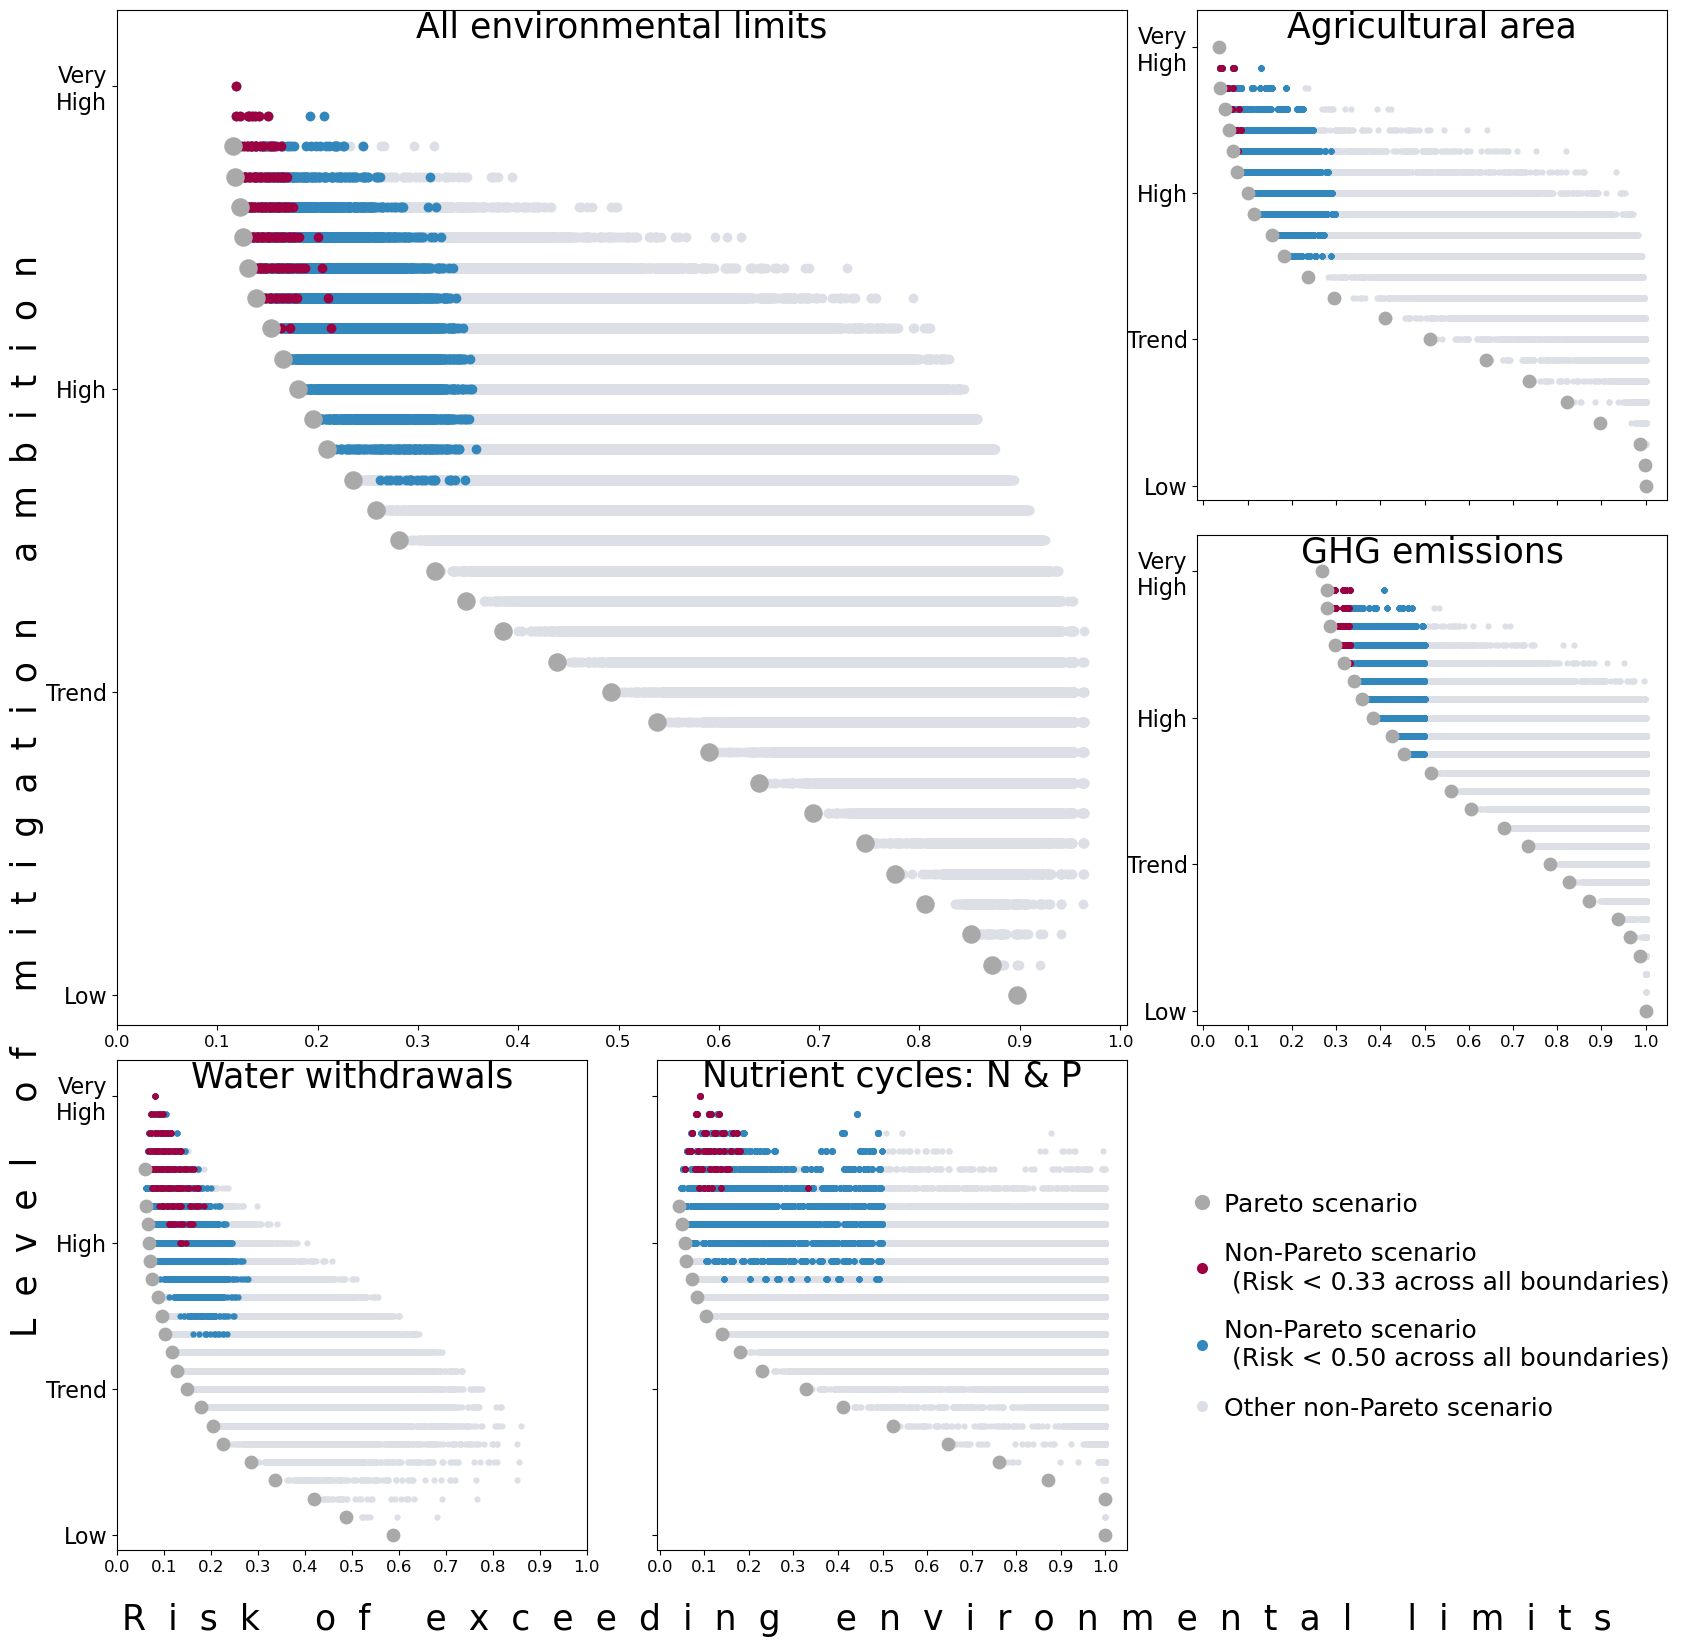

In [38]:
import matplotlib.patches as patches
from matplotlib.path import Path
from matplotlib.patches import BoxStyle
from matplotlib.lines import Line2D
import matplotlib.image as mpimg
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import heapq


pd_scenario = {}
pd_scenario2 = {} # pareto scenarios at each risk level

# Create axes
# Create grids and axes
fig = plt.figure(figsize=(20, 20))

# Set the width ratio of subplots (main plot, side plot)
#width_ratios = [2,.25]
grid = plt.GridSpec(3, 3, hspace=0.07, wspace=0.15)

axes = {}

axes['all_boundaries'] = fig.add_subplot(grid[0:2,0:2])
axes['Freshwater_Use'] = fig.add_subplot(grid[2,0])
#axes['Biogeochemical_Flows_P'] = fig.add_subplot(grid[2,1], sharey=axes['Biogeochemical_Flows_N'])
axes['Biogeochemical_Flows'] = fig.add_subplot(grid[2,1], sharey=axes['Freshwater_Use']) 
axes['Land_system_change'] = fig.add_subplot(grid[0,2])#, sharex=axes['Land_system_change'])
axes['Climate_Change'] = fig.add_subplot(grid[1,2], sharex=axes['Land_system_change'])

risk_levels_dict = {50:'High risk', 25:'Moderate risk', 10:'Low risk'}#, 5:'Low risk'}

for i, b in enumerate(['all_boundaries']+boundaries): #

    
    #p_front_x, p_front_y = column(p_front[b], obj1[b]), column(p_front[b], obj2[b])
    p_front_x, p_front_y = list(pd_p_front[b]['Risk_'+b]), list(pd_p_front[b]['Ambition_'+b])
    
    # because all boundaries risk doesn't have risk color, we have to make this conditional term
    if b == 'all_boundaries':
        p_front_c = ['#dcdfe5' for x in list(pd_p_front[b]['Risk_all_boundaries'])] # We use RiskCol_Climate_Change just to know the length of the list. The values don't matter as they will be replaced with the same colour  
    else: 
        p_front_c = list(pd_p_front[b]['Risk_'+b])
    
    # Derive the representative scenarios from the pareto set bsaed on the most achievabel scenario in all boundaries fin 5, 25, 50, 95% of risk. 

    # First, in the pareto solution set, sort the risk colour and ambition based on the risk value (reverse)
    sorted_p_front_y = [y for _,y in sorted(zip(p_front_x,p_front_y), reverse=True)]
    sorted_p_front_c = [c for _,c in sorted(zip(p_front_x,p_front_c), reverse=True)]
    sorted_p_front_x = sorted(p_front_x, reverse=True)

    # Second, find the 5, 25, 50, 95 percentiles of risk and their equivalent ambition based the all_boundaries dataframe
    for p in list(risk_levels_dict.keys()):
        # This condition is to only use the all_boundaries dataframe for selecting representative scenarios
        if b == 'all_boundaries':
            a = np.array(sorted_p_front_x)
            prc = np.percentile(a,p)
            n = 0
            for itm in sorted_p_front_x:
                if itm<prc and n==0:
                    idx = sorted_p_front_x.index(itm)
                    n += 1
            pd_scenario[(b, risk_levels_dict[p])] = pd_p_front[b].loc[(pd_p_front[b]['Risk_'+b] == sorted_p_front_x[idx]) & (pd_p_front[b]['Ambition_'+b] == sorted_p_front_y[idx])]
        else:
            # We find all individual boundary pareto datafarmes what sceanrios have specific risk and ambition and shared solution values equal to one in the representative scenarios from all_boundarues dataframe
            pd_scenario[(b, risk_levels_dict[p])] = temp_results_dict2[b].loc[(temp_results_dict2[b]['Risk_'+b] == list(pd_scenario[('all_boundaries', risk_levels_dict[p])]['Risk_'+b])[0]) 
                                                                              & (temp_results_dict2[b]['Ambition_'+b] == list(pd_scenario[('all_boundaries', risk_levels_dict[p])]['Ambition_'+b])[0]) 
                                                                              & (temp_results_dict2[b]['Pop_levels'] == list(pd_scenario[('all_boundaries', risk_levels_dict[p])]['Pop_levels'])[0]) 
                                                                              & (temp_results_dict2[b]['Diet'] == list(pd_scenario[('all_boundaries', risk_levels_dict[p])]['Diet'])[0]) 
                                                                              & (temp_results_dict2[b]['Waste'] == list(pd_scenario[('all_boundaries', risk_levels_dict[p])]['Waste'])[0]) 
                                                                              & (temp_results_dict2[b]['Yield_levels'] == list(pd_scenario[('all_boundaries', risk_levels_dict[p])]['Yield_levels'])[0]) 
                                                                              & (temp_results_dict2[b]['Feed_efficiency'] == list(pd_scenario[('all_boundaries', risk_levels_dict[p])]['Feed_efficiency'])[0]) 
                                                                              & (temp_results_dict2[b]['Feed_composition'] == list(pd_scenario[('all_boundaries', risk_levels_dict[p])]['Feed_composition'])[0]) 
                                                                              & (temp_results_dict2[b]['Plant_kcal'] == list(pd_scenario[('all_boundaries', risk_levels_dict[p])]['Plant_kcal'])[0]) 
                                                                              & (temp_results_dict2[b]['Pred_avg_'+b] == list(pd_scenario[('all_boundaries', risk_levels_dict[p])]['Pred_avg_'+b])[0])]
            
            # We remove the name of boundary from the column headers as now we have dataframe per each boundary. This is needed for later dataprocessing in the wheel chart.
            pd_scenario2[(b, risk_levels_dict[p])] = pd_scenario[(b, risk_levels_dict[p])].copy()
            pd_scenario2[(b, risk_levels_dict[p])].rename(columns={'Risk_'+b: 'Risk'}, inplace=True)
            #pd_scenario2[(b, risk_levels_dict[p])].rename(columns={'RiskCol_'+b: 'RiskCol'}, inplace=True)
            pd_scenario2[(b, risk_levels_dict[p])].rename(columns={'Pred_avg_'+b: 'Pred_avg'}, inplace=True)
            pd_scenario2[(b, risk_levels_dict[p])].rename(columns={'Max_'+b: 'Max'}, inplace=True)
            pd_scenario2[(b, risk_levels_dict[p])].rename(columns={'Min_'+b: 'Min'}, inplace=True)
            pd_scenario2[(b, risk_levels_dict[p])].rename(columns={'Mode_'+b: 'Mode'}, inplace=True)
            pd_scenario2[(b, risk_levels_dict[p])].rename(columns={'Pred_SD_'+b: 'Pred_SD'}, inplace=True)
            pd_scenario2[(b, risk_levels_dict[p])].rename(columns={'Ambition_'+b: 'Ambition'}, inplace=True)
            


    # Draw the pareto front
    if b == 'all_boundaries':
        #First, transform single column dataframe to a list
        x_list = All_results_dict['Risk_'+b].tolist()
        y_list = All_results_dict['Ambition_'+b].tolist()
        x_list2 = All_results_reduced_risk['Risk_'+b].tolist()
        y_list2 = All_results_reduced_risk['Ambition_'+b].tolist()
        x_list3 = All_results_low_risk['Risk_'+b].tolist()
        y_list3 = All_results_low_risk['Ambition_'+b].tolist()
        # Adjust the size of markers
        size1 = 3
        size2 = 1.9
    else:
        x_list = temp_results_dict2[b]['Risk_'+b].tolist()
        y_list = temp_results_dict2[b]['Ambition_'+b].tolist()
        x_list2 = All_results_reduced_risk['Risk_'+b].tolist()
        y_list2 = All_results_reduced_risk['Ambition_'+b].tolist()
        x_list3 = All_results_low_risk['Risk_'+b].tolist()
        y_list3 = All_results_low_risk['Ambition_'+b].tolist()
        size1 = 1
        size2 = 1
        
    # Plot all scenarios across subplots
    if b == 'all_boundaries':
        axes[b].scatter(x_list, y_list, color='#dcdfe5', s=12*size1)
        axes[b].scatter(x_list2, y_list2, color='#3288BD', s=12*size1)
        axes[b].scatter(x_list3, y_list3, color='#9E0142', s=12*size1) 
    else:
        axes[b].scatter(x_list, y_list, color='#dcdfe5', s=12*size1)
        axes[b].scatter(x_list2, y_list2, color='#3288BD', s=12*size1)
        axes[b].scatter(x_list3, y_list3, color='#9E0142', s=12*size1) 
    
    # Plot the pareto fronts across all subplots
    #axes[b].scatter(p_front_x, p_front_y, marker='o', color=p_front_c, edgecolor='lightgrey', linewidth=1, s=140*size2)
    axes[b].scatter(p_front_x, p_front_y, marker='o', color='darkgray', edgecolor=None, linewidth=1, s=80*size2)
    
    # Plot representative scenarios in all subplots
#     marker_shape = {'High risk':"D", 'Moderate risk':"s", 'Low risk':'*'}#, 'Low risk':"X"}
#     marker_size = {'High risk':90*size2, 'Moderate risk':90*size2, 'Low risk':250*size2}#, 'Low risk':150*size2}
#     for l in risk_levels_dict.values():
#         axes[b].scatter(list(pd_scenario[('all_boundaries', l)]['Risk_'+b]), 
#                             list(pd_scenario[('all_boundaries', l)]['Ambition_'+b]), 
#                             marker=marker_shape[l], color='none', edgecolor='blue', linewidth=1.4, s=marker_size[l])
        
    if penalty=='yes':
        y_ticks = [-1, 0, 1, 4]
    else:
        y_ticks = [-1, 0, 1, 2]
        
    y_tick_labels = ['Low', 'Trend','High', 'Very\nHigh']
    #x_ticks = np.arange(round(All_results_dict['Risk_'+b].min(),1), 1.1, .2).tolist()
    #x_ticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    x_ticks = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    x_tick_labels = x_ticks
    
    axes[b].set_title(boundaries_name[b], y=1.0, fontsize=25, pad=-20)
    
    # Set a consistent range for all y axis
    #axes[b].set_ylim([-1.1, 2.1])
    if penalty=='yes':
        axes[b].set_ylim([-1.1, 4.1])
    else:
        axes[b].set_ylim([-1.1, 2.25])
    # Remove unnecessary ticks and labels
    if b in ['all_boundaries', 'Freshwater_Use']:
        axes[b].yaxis.set_ticks(y_ticks)
        axes[b].set_yticklabels(y_tick_labels, fontsize=16)
    elif b in ['Climate_Change','Land_system_change']:
        axes[b].yaxis.set_ticks(y_ticks)
        axes[b].set_yticklabels(y_tick_labels, fontsize=16)
        #axes[b].set_yticklabels([])
    else:
        axes[b].tick_params(axis='y', direction='out', labelleft=False)

    if b in ['all_boundaries', 'Biogeochemical_Flows', 'Climate_Change',"Freshwater_Use"]:
        #axes[b].tick_params(axis='x', labelsize=13)
        axes[b].xaxis.set_ticks(x_ticks)
        axes[b].set_xticklabels(x_tick_labels, fontsize=12)
    else:
        axes[b].tick_params(axis='x', direction='out', labelbottom=False)
    
    
#     # Print the boundary icon 
#     img_dir = 'M:/Current-Users/Michalis-Hadjikakou/Food_Meta_analysis/Figs/PB_icons/'

#     img = mpimg.imread(img_dir+b+'.png')
#     if b in ['Biogeochemical_Flows_N', 'Biogeochemical_Flows_P']:
#         zoom = .15
#         xloc = 0.08
#     else:
#         zoom = .5
#         xloc = 0.11
        
#     if b in ['all_boundaries']:
#         yloc = 0.15
#     else:
#         yloc = 0.1
#     imagebox = OffsetImage(img, zoom=zoom)
    
#     ab = AnnotationBbox(imagebox, (xloc, yloc), xycoords='axes fraction',  frameon=False)
#     axes[b].add_artist(ab)


    
fig.text(0.5, 0.07, "  ".join('Risk of exceeding environmental limits'), ha='center', fontsize=25)
fig.text(0.08, 0.22, "  ".join('Level of mitigation ambition'), ha='center', fontsize=25, rotation='vertical')


    
# Create legend
legend_elements = []


legend_elements.append(Line2D([0], [0], marker="o", color='none', label='Pareto scenario', 
                                  markersize=12, markeredgecolor='white', markerfacecolor='darkgray', alpha=1))
#mediumpurple
legend_elements.append(Line2D([0], [0], marker="o", color='none', label='Non-Pareto scenario \n (Risk < 0.33 across all boundaries)', 
                                  markersize=9, markeredgecolor='white', markerfacecolor='#9E0142', alpha=1))

legend_elements.append(Line2D([0], [0], marker="o", color='none', label='Non-Pareto scenario \n (Risk < 0.50 across all boundaries)', 
                                  markersize=9, markeredgecolor='white', markerfacecolor='#3288BD', alpha=1))

legend_elements.append(Line2D([0], [0], marker="o", color='none', label='Other non-Pareto scenario', 
                                  markersize=9, markeredgecolor='white', markerfacecolor='#dcdfe5', alpha=1))
# for r in list(risk_colour.keys()):
#     legend_elements.append(Line2D([0], [0], marker="o", color='none', label=risk_label[r], 
#                                   markersize=15, markeredgecolor='white', markerfacecolor=risk_colour[r], alpha=1))
# # legend_elements.append(Line2D([0], [0], marker="*", color='none', label='5th percentile risk', 
# #                                   markersize=18, markeredgecolor='blue', markerfacecolor='none', alpha=1))
# legend_elements.append(Line2D([0], [0], marker="*", color='none', label='10th percentile risk', 
#                                   markersize=18, markeredgecolor='blue', markerfacecolor='none', alpha=1))
# legend_elements.append(Line2D([0], [0], marker="s", color='none', label='25th percentile risk', 
#                                   markersize=15, markeredgecolor='blue', markerfacecolor='none', alpha=1))
# legend_elements.append(Line2D([0], [0], marker="D", color='none', label='50th percentile risk', 
#                                   markersize=15, markeredgecolor='blue', markerfacecolor='none', alpha=1))

fig.legend(handles=legend_elements, #loc='lower right', #bbox_to_anchor=(.05, 0.03, .4, .05), 
           frameon=False, ncol=1, loc='upper left', bbox_to_anchor=(0.65, 0.3),
           #bbox_transform=fig.transFigure, 
           handlelength=1, columnspacing=1, handletextpad=.4, labelspacing=1, fontsize=18, handleheight=1)


plt.savefig('{}/Fig_SM_Risk_Ambition_Pareto.png'.format(r'//school-les-m.shares.deakin.edu.au/school-les-m/Planet-A/Food-Systems/Meta_analysis/GFSI-MRM/GFSI-MRM/Outputs/Pareto_analysis+plots/'), dpi=600,  bbox_inches='tight') 
